In [1]:
# imports

import glob
import math
import os
import pickle
import random
import tempfile
import time
import urllib
from datetime import datetime, timedelta
from io import StringIO
from typing import List
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pytz
import seaborn as sns
import torch
from pandas.plotting import register_matplotlib_converters
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

register_matplotlib_converters()
%matplotlib inline
sns.set_style("whitegrid")

2023-03-06 19:45:38.951709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load preprocessed data from 10 nodes in the bay area

df = pd.read_csv("processed.csv")

In [3]:
df = df.drop(
    [
        "Unnamed: 0",
        "INTERVALENDTIME_GMT",
        "OPR_DT",
        "OPR_HR",
        "NODE_ID_XML",
        "NODE_ID",
        "NODE",
        "MARKET_RUN_ID",
        "LMP_TYPE",
        "XML_DATA_ITEM",
        "PNODE_RESMRID",
        "GRP_TYPE",
    ],
    axis=1,
)

In [4]:
train_set_length = int(round((df.shape[0] * 0.75), 0))
test_set_length = df.shape[0] - train_set_length

print(f"\nTrain: {train_set_length} rows\nTest:  {test_set_length} rows")

train = df.iloc[:train_set_length]
test = df.iloc[train_set_length:]

print(f"\nTrain set shape: {train.shape}\nTest set shape:  {test.shape}\n")


Train: 2344464 rows
Test:  781488 rows

Train set shape: (2344464, 15)
Test set shape:  (781488, 15)



In [5]:
train = train.set_index("INTERVALSTARTTIME_GMT")
test = test.set_index("INTERVALSTARTTIME_GMT")

In [6]:
features = [col for col in train.columns if col != "VALUE"]
print(len(features))
print(features)

13
['POS', 'OPR_INTERVAL', 'GROUP', 'HOUR', '2DA', '7DA', 'ACTUAL', 'DAM', 'ETo (in)', 'Precip (in)', 'Rel Hum (%)', 'Wind Speed (mph)', 'Soil Temp (F)']


In [7]:
X_train = train[features]
y_train = train["VALUE"]

X_test = test[features]
y_test = test["VALUE"]

# Classic Machine Learning Models

## Linear Regression

Linear Regression is the most basic regression model.

In [47]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

In [48]:
prediction = reg.predict(X_test)

In [50]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(y_test, prediction))
print(f"RMSE Score on LinearRegression Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, prediction)
print(f"MAE Score on LinearRegression Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, prediction)
print(f"MAPE Score on LinearRegression Test set: {mape:0.3f}")
r2 = r2_score(y_test, prediction)
print(f"R2 Score on LinearRegression Test set: {r2:0.3f}")

RMSE Score on LinearRegression Test set: 1.065
MAE Score on LinearRegression Test set: 0.479
MAPE Score on LinearRegression Test set: 1.562
R2 Score on LinearRegression Test set: -0.011


## XGBoost

XGBoost (eXtreme Gradient Boosting) is an open-source software library which provides a regularizing gradient boosting framework. It aims to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library". It runs on a single machine, as well as the distributed processing frameworks Apache Hadoop, Apache Spark, Apache Flink, and Dask.



In [51]:
# Xgboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=10000,
    early_stopping_rounds=50,
    objective="reg:linear",
    max_depth=10,
    learning_rate=0.01,
)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[20:06:14] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10761	validation_1-rmse:1.13717
[100]	validation_0-rmse:0.95275	validation_1-rmse:1.05259
[200]	validation_0-rmse:0.92183	validation_1-rmse:1.04798
[223]	validation_0-rmse:0.91895	validation_1-rmse:1.04832


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [52]:
prediction = reg.predict(X_test)

In [53]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(y_test, prediction))
print(f"RMSE Score on XGBRegressor Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, prediction)
print(f"MAE Score on XGBRegressor Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, prediction)
print(f"MAPE Score on XGBRegressor Test set: {mape:0.3f}")
r2 = r2_score(y_test, prediction)
print(f"R2 Score on XGBRegressor Test set: {r2:0.3f}")

RMSE Score on XGBRegressor Test set: 1.048
MAE Score on XGBRegressor Test set: 0.495
MAPE Score on XGBRegressor Test set: 2.790
R2 Score on XGBRegressor Test set: 0.022


# Innovative Machine Learning Models

## RNN (LSTM, GRU)

In [54]:
import tensorflow as tf
from keras import regularizers
from keras.layers import GRU, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [55]:
# Time Series Generator Parameters

lookback_length = 12
batch_size = 64

In [56]:
train_sequences = TimeseriesGenerator(
    X_train, y_train, length=lookback_length, batch_size=batch_size
)
batch_x, batch_y = train_sequences[0]

In [57]:
test_sequences = TimeseriesGenerator(
    X_test, y_test, length=lookback_length, batch_size=batch_size
)

batch_x_test, batch_y_test = train_sequences[0]

In [58]:
with tf.device("/gpu:0"):
    model = Sequential()

    model.add(
        GRU(16, input_shape=(batch_x.shape[1], batch_x.shape[2]), return_sequences=True)
    )

    model.add(GRU(16))

    model.add(Dense(32, activation="relu"))
    # model.add(Dropout(0.1))                  # refers to nodes in the first hidden layer

    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.1))

    model.add(Dense(8, activation="relu"))
    # model.add(Dropout(0.1))

    model.add(Dense(1, activation="linear"))

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 16)            1488      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense_34 (Dense)            (None, 32)                544       
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 8)                 136       
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,337
Trainable params: 4,337
Non-trainabl

In [59]:
# GRU

with tf.device("/gpu:0"):
    model.compile(optimizer=Adam(lr=0.0005), loss="mean_squared_error")

    history = model.fit_generator(
        train_sequences,
        validation_data=test_sequences,
        epochs=1,
        verbose=1,
        use_multiprocessing=True,
    )

/home/zyan/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_4987/3278019805.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


36633/36633 [==============================] - 397s 11ms/step - loss: 0.9517 - val_loss: 1.1246


In [60]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred = model.predict(batch_x_test)
score = np.sqrt(mse(pred, batch_y_test))
print(f"RMSE Score on GRU Test set: {score:0.3f}")
mae = mean_absolute_error(pred, batch_y_test)
print(f"MAE Score on GRU Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, batch_y_test)
print(f"MAPE Score on GRU Test set: {mape:0.3f}")
r2 = r2_score(pred, batch_y_test)
print(f"R2 Score on GRU Test set: {r2:0.3f}")

2/2 [==============================] - 0s 2ms/step
RMSE Score on GRU Test set: 0.277
MAE Score on GRU Test set: 0.276
MAPE Score on GRU Test set: 2.404
R2 Score on GRU Test set: -19712.803


In [61]:
# %%LSTM Model
model1 = Sequential()
model1.add(
    LSTM(
        120,
        return_sequences=True,
        input_shape=(batch_x.shape[1], batch_x.shape[2]),
    )
)
model1.add(LSTM(80, return_sequences=True))
model1.add(LSTM(40))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 120)           64320     
                                                                 
 lstm_1 (LSTM)               (None, 12, 80)            64320     
                                                                 
 lstm_2 (LSTM)               (None, 40)                19360     
                                                                 
 dense_38 (Dense)            (None, 1)                 41        
                                                                 
Total params: 148,041
Trainable params: 148,041
Non-trainable params: 0
_________________________________________________________________


In [62]:
# LSTM
model1.compile(optimizer=Adam(lr=0.0005), loss="mean_squared_error")

history1 = model.fit_generator(
    train_sequences, validation_data=test_sequences, epochs=1, verbose=1
)

   22/36633 [..............................] - ETA: 3:00 - loss: 0.6058

/home/zyan/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_4987/2376662000.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(


36633/36633 [==============================] - 219s 6ms/step - loss: 0.9392 - val_loss: 1.1140


In [63]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred = model.predict(batch_x_test)
score = np.sqrt(mse(pred, batch_y_test))
print(f"RMSE Score on LSTM Test set: {score:0.3f}")
mae = mean_absolute_error(pred, batch_y_test)
print(f"MAE Score on LSTM Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, batch_y_test)
print(f"MAPE Score on LSTM Test set: {mape:0.3f}")
r2 = r2_score(pred, batch_y_test)
print(f"R2 Score on LSTM Test set: {r2:0.3f}")

2/2 [==============================] - 0s 2ms/step
RMSE Score on LSTM Test set: 0.225
MAE Score on LSTM Test set: 0.223
MAPE Score on LSTM Test set: 1.335
R2 Score on LSTM Test set: -1838.638


In [8]:
# Transformer
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
 
    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Attention layer
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)



In [44]:
input_shape = batch_x.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.5,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    batch_x,
    batch_y,
    validation_split=0.1,
    epochs=100,
    batch_size=512,
    callbacks=callbacks,
)

model.evaluate(batch_x_test, batch_y_test, verbose=1)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2240 - val_loss: 0.0350
Epoch 2/100
1/1 [==============================] - 0s 107ms/step - loss: 0.1671 - val_loss: 0.0363
Epoch 3/100
1/1 [==============================] - 0s 98ms/step - loss: 0.1355 - val_loss: 0.0378
Epoch 4/100
1/1 [==============================] - 0s 97ms/step - loss: 0.0941 - val_loss: 0.0404
Epoch 5/100
1/1 [==============================] - 0s 101ms/step - loss: 0.0805 - val_loss: 0.0416
Epoch 6/100
1/1 [==============================] - 0s 99ms/step - loss: 0.0768 - val_loss: 0.0418
Epoch 7/100
1/1 [==============================] - 0s 100ms/step - loss: 0.0774 - val_loss: 0.0420
Epoch 8/100
1/1 [==============================] - 0s 97ms/step - loss: 0.0722 - val_loss: 0.0386
Epoch 9/100
1/1 [==============================] - 0s 98ms/step - loss: 0.0575 - val_loss: 0.0359
Epoch 10/100
1/1 [==============================] - 0s 102ms/step - loss: 0.0762 - val_loss: 0.0340
Epoch 11/100
1/1 

0.010519315488636494

In [1]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred = model.predict(batch_x_test)
score = np.sqrt(mse(pred, batch_y_test))
print(f"RMSE Score on vanilla Transformer Test set: {score:0.3f}")
mae = mean_absolute_error(pred, batch_y_test)
print(f"MAE Score on vanilla Transformer Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, batch_y_test)
print(f"MAPE Score on vanilla Transformer Test set: {mape:0.3f}")
r2 = r2_score(pred, batch_y_test)
print(f"R2 Score on vanilla Transformer Test set: {r2:0.3f}")

NameError: name 'model' is not defined

## Our Proposed Model

In [3]:
# dense -> MLP             -\
# sparse -> nn.Embedding   --  MLP


class ElectricyMarketPriceModule(pl.LightningModule):
    def __init__(self):
        super().__init__()

        embedding_dim = 32
        self._dense_mlp = nn.Sequential(
            nn.LazyLinear(32),
            nn.Tanh(),
        )
        self._month_emb = nn.Embedding(12, embedding_dim)
        self._hour_emb = nn.Embedding(24, embedding_dim)
        self._weekday_emb = nn.Embedding(7, embedding_dim)
        self._sparse_mlp = nn.Sequential(
            nn.LazyLinear(32),
            nn.Tanh(),
        )
        # self._transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
        self._multihead_attn = nn.MultiheadAttention(32 + 32, 8)
        self._over_mlp = nn.Sequential(
            nn.LazyLinear(64),
            nn.Tanh(),
            nn.LazyLinear(6),
        )

        self.loss = nn.MSELoss()

    def training_step(self, batch):
        dense, sparse, label = batch
        # print(f"dense = {dense}")
        # print(f"sparse = {sparse}")
        # print(f"label = {label}")
        # raise Exception()

        B = dense.size(0)
        dense_out = self._dense_mlp(dense)
        month_embs = self._month_emb(sparse[:, :, 0])
        hour_embs = self._hour_emb(sparse[:, :, 1])
        weekday_embs = self._weekday_emb(sparse[:, :, 2])
        sparse_out = self._sparse_mlp(
            torch.cat([month_embs, hour_embs, weekday_embs], dim=-1)
        )
        attn_input = torch.cat([dense_out, sparse_out], dim=-1)
        attn_output, _ = self._multihead_attn(
            attn_input, attn_input, attn_input, need_weights=False
        )  # [B, 288, 68]
        pred = self._over_mlp(attn_output.view(B, -1))
        # print(f'pred {pred}')
        # print(f'label {label}')
        loss = self.loss(pred, label)
        # print(f'loss {loss}')
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.cnn_net(x)
        out = out.view(x.size(0), -1)
        pred = self.linear_net(out)
        pred = torch.argmax(pred, dim=1)
        self.log("val_loss", (pred == y).sum().item() / x.size(0), prog_bar=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.cnn_net(x)
        out = out.view(x.size(0), -1)
        pred = self.linear_net(out)
        pred = torch.argmax(pred, dim=1)
        self.log("test_loss", (pred == y).sum().item() / x.size(0))

    def predict_step(self, batch, batch_idx):
        dense, sparse, label = batch
        # print(f"dense = {dense}")
        # print(f"sparse = {sparse}")
        # print(f"label = {label}")
        # raise Exception()

        B = dense.size(0)
        dense_out = self._dense_mlp(dense)
        month_embs = self._month_emb(sparse[:, :, 0])
        hour_embs = self._hour_emb(sparse[:, :, 1])
        weekday_embs = self._weekday_emb(sparse[:, :, 2])
        sparse_out = self._sparse_mlp(
            torch.cat([month_embs, hour_embs, weekday_embs], dim=-1)
        )
        attn_input = torch.cat([dense_out, sparse_out], dim=-1)
        attn_output, _ = self._multihead_attn(
            attn_input, attn_input, attn_input, need_weights=False
        )  # [B, 288, 68]
        pred = self._over_mlp(attn_output.view(B, -1))
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer, gamma=0.95, verbose=True
        )
        return [optimizer], [lr_scheduler]

In [4]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, df, years: List[int]):
        super(MyIterableDataset).__init__()

        self._df = df

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        assert (
            worker_info is None
        )  # single-process data loading, return the full iterator

        price_list: List[float] = []
        dense_list: List[List[float]] = []
        month_list: List[int] = []
        hour_list: List[int] = []
        weekday_list: List[int] = []

        for index, row in self._df.iterrows():
            # 24 hours for training, 1 hour for ground truth
            if len(price_list) == 24 * 12 + 12 * 24:
                indices = list(range(0, 24 * 12, 12))
                yield torch.tensor(
                    [dense_list[i] for i in indices], dtype=torch.float
                ), torch.tensor(
                    list(
                        zip(
                            [month_list[i] for i in indices],
                            [hour_list[i] for i in indices],
                            [weekday_list[i] for i in indices],
                        )
                    ),
                    dtype=torch.int,
                ), torch.tensor(
                    [
                        price_list[24 * 12],
                        price_list[24 * 12 + 11],
                        price_list[24 * 12 + 12 * 2 - 1],
                        price_list[24 * 12 + 12 * 4 - 1],
                        price_list[24 * 12 + 12 * 12 - 1],
                        price_list[24 * 12 + 12 * 24 - 1],
                    ],
                    dtype=torch.float,
                ),

                # 5 minutes, one hour, 2 hours, 4 hours, 12 hours, 24 hours

                price_list.pop(0)
                dense_list.pop(0)
                month_list.pop(0)
                hour_list.pop(0)
                weekday_list.pop(0)

            price_list.append(float(row["VALUE"]))
            dense_list.append([float(row["VALUE"])] + row[df.columns[-9:]].tolist())
            curt_dt = datetime.strptime(
                row["INTERVALSTARTTIME_GMT"], "%Y-%m-%dT%H:%M:00-00:00"
            ) + timedelta(hours=8)
            month_list.append(curt_dt.month - 1)
            hour_list.append(curt_dt.hour)
            weekday_list.append(curt_dt.weekday())


train_dataset = MyIterableDataset(df, years=[2020, 2021])
test_dataset = MyIterableDataset(df, years=[2022])

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        print(f'linear {m}')
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Embedding):
        print(f'embedding {m}')
        nn.init.uniform_(m.weight, -1.0, 1.0)

module = ElectricyMarketPriceModule()

batch = next(iter(DataLoader(train_dataset, batch_size=32)))
module.training_step(batch)
module.apply(init_weights)
module.training_step(batch)

/home/zyan/miniconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


linear Linear(in_features=10, out_features=32, bias=True)
embedding Embedding(12, 32)
embedding Embedding(24, 32)
embedding Embedding(7, 32)
linear Linear(in_features=96, out_features=32, bias=True)
linear NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
linear Linear(in_features=1536, out_features=64, bias=True)
linear Linear(in_features=64, out_features=6, bias=True)


/home/zyan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/tmp/ipykernel_110067/1710434713.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


tensor(0.8116, grad_fn=<MseLossBackward0>)

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")
trainer = pl.Trainer(
    max_epochs=1,
    callbacks=[lr_monitor],
    logger=TensorBoardLogger("tb_logs", name="my_model"),
    accelerator="gpu",  # accelerator="gpu",
)
trainer.fit(module, DataLoader(train_dataset, batch_size=512))

In [27]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(pred, test))
print(f"RMSE Score on Transformer Test set: {score:0.3f}")
mae = mean_absolute_error(pred, test)
print(f"MAE Score on Transformer Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, test)
print(f"MAPE Score on Transformer Test set: {mape:0.3f}")

RMSE Score on Transformer Test set: 0.057
MAE Score on Transformer Test set: 0.049
MAPE Score on Transformer Test set: 0.149


## Trading

In [ ]:
# baseline: buy at at 9pm - 9am, sell at 9am - 9pm

balance = 0.0
charged = 0.0
naive_dts = []
naive_balances = []
naive_remainings = []

CAPACITY = 13.3
CHARGE_SPEED = 3.3

price_list: List[float] = []
month_list: List[int] = []
hour_list: List[int] = []
weekday_list: List[int] = []


pbar = tqdm(df.iterrows())
for index, row in pbar:
    price = float(row["VALUE"])
    price_list.append(float(row["VALUE"]))
    curt_dt = datetime.strptime(
        row["INTERVALSTARTTIME_GMT"], "%Y-%m-%dT%H:%M:00-00:00"
    ) + timedelta(hours=8)
    month_list.append(curt_dt.month - 1)
    hour_list.append(curt_dt.hour)
    weekday_list.append(curt_dt.weekday())

    if curt_dt.year != 2022:
        if curt_dt.hour == 0:
            pbar.set_description(f"{curt_dt}")
        continue

    # trade at minute 0
    if curt_dt.minute == 0:
        naive_dts.append(curt_dt)
        naive_balances.append(balance)
        naive_remainings.append(charged)

        if curt_dt.hour >= 9 and curt_dt.hour < 21:
            if charged > 0:
                balance += price * (CAPACITY / 12)
                charged -= CAPACITY / 12
        else:
            if charged < CAPACITY:
                balance -= price * (CAPACITY / 12)
                charged += CAPACITY / 12

        if curt_dt.hour == 0:
            pbar.set_description(f"{curt_dt} {balance}")

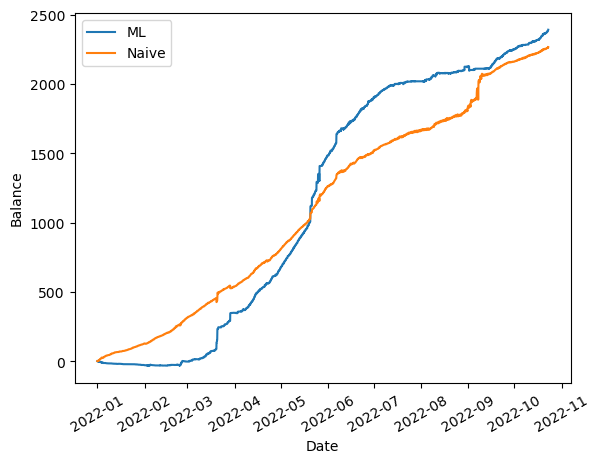

In [39]:
import matplotlib.pyplot as plt

plt.plot(dts, balances, label="ML")
plt.plot(naive_dts, naive_balances, label="Naive")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Balance")
plt.legend()
plt.show()